In [65]:
DATA_SOURCE = 'https://raw.githubusercontent.com/casca/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

dataset = pd.read_json(DATA_SOURCE)

footer = f'Source https://github.com/pcm-dpc/COVID-19 - Last Updated {dataset["data"].tolist()[-1]}'

# format and sort by date
dataset['data'] = dataset['data'].transform(lambda s: s[:10])
dataset.sort_values(by=['data'], inplace=True)
dataset['data'] = pd.to_datetime(dataset['data'])
dataset['data'] = dataset['data'].dt.strftime('%d %b')

measures = {
            'deceduti': 'Deaths',
            'terapia_intensiva': 'Intensive Care',
            'dimessi_guariti': 'Recovered',
            'totale_casi': 'Total Cases'
           }

sub_measures = {
                'delta': { 'color': 'plum', 'label': 'First Derivative', 'is_percentage': False },
                'delta_2': { 'color': 'sandybrown', 'label': 'Second Derivative', 'is_percentage': False },
                'delta_3': { 'color': 'yellowgreen', 'label': 'Third Derivative', 'is_percentage': False }
               }

for measure in measures:
    dataset[f'{measure}_delta'] = dataset[measure].diff()
    dataset[f'{measure}_delta_2'] = dataset[f'{measure}_delta'].diff()
    dataset[f'{measure}_delta_3'] = dataset[f'{measure}_delta_2'].diff()

dataset.dropna(inplace=True)

dataset.tail(3)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,...,deceduti_delta_3,terapia_intensiva_delta,terapia_intensiva_delta_2,terapia_intensiva_delta_3,dimessi_guariti_delta,dimessi_guariti_delta_2,dimessi_guariti_delta_3,totale_casi_delta,totale_casi_delta_2,totale_casi_delta_3
26,21 Mar,ITA,17708,2857,20565,22116,42681,4821,6072,4825,...,-34.0,202.0,45.0,129.0,943.0,254.0,-20.0,6557.0,571.0,-93.0
27,22 Mar,ITA,19846,3009,22855,23783,46638,3957,7024,5476,...,-308.0,152.0,-50.0,-95.0,952.0,9.0,-245.0,5560.0,-997.0,-1568.0
28,23 Mar,ITA,20692,3204,23896,26522,50418,3780,7432,6077,...,92.0,195.0,43.0,93.0,408.0,-544.0,-553.0,4789.0,-771.0,226.0


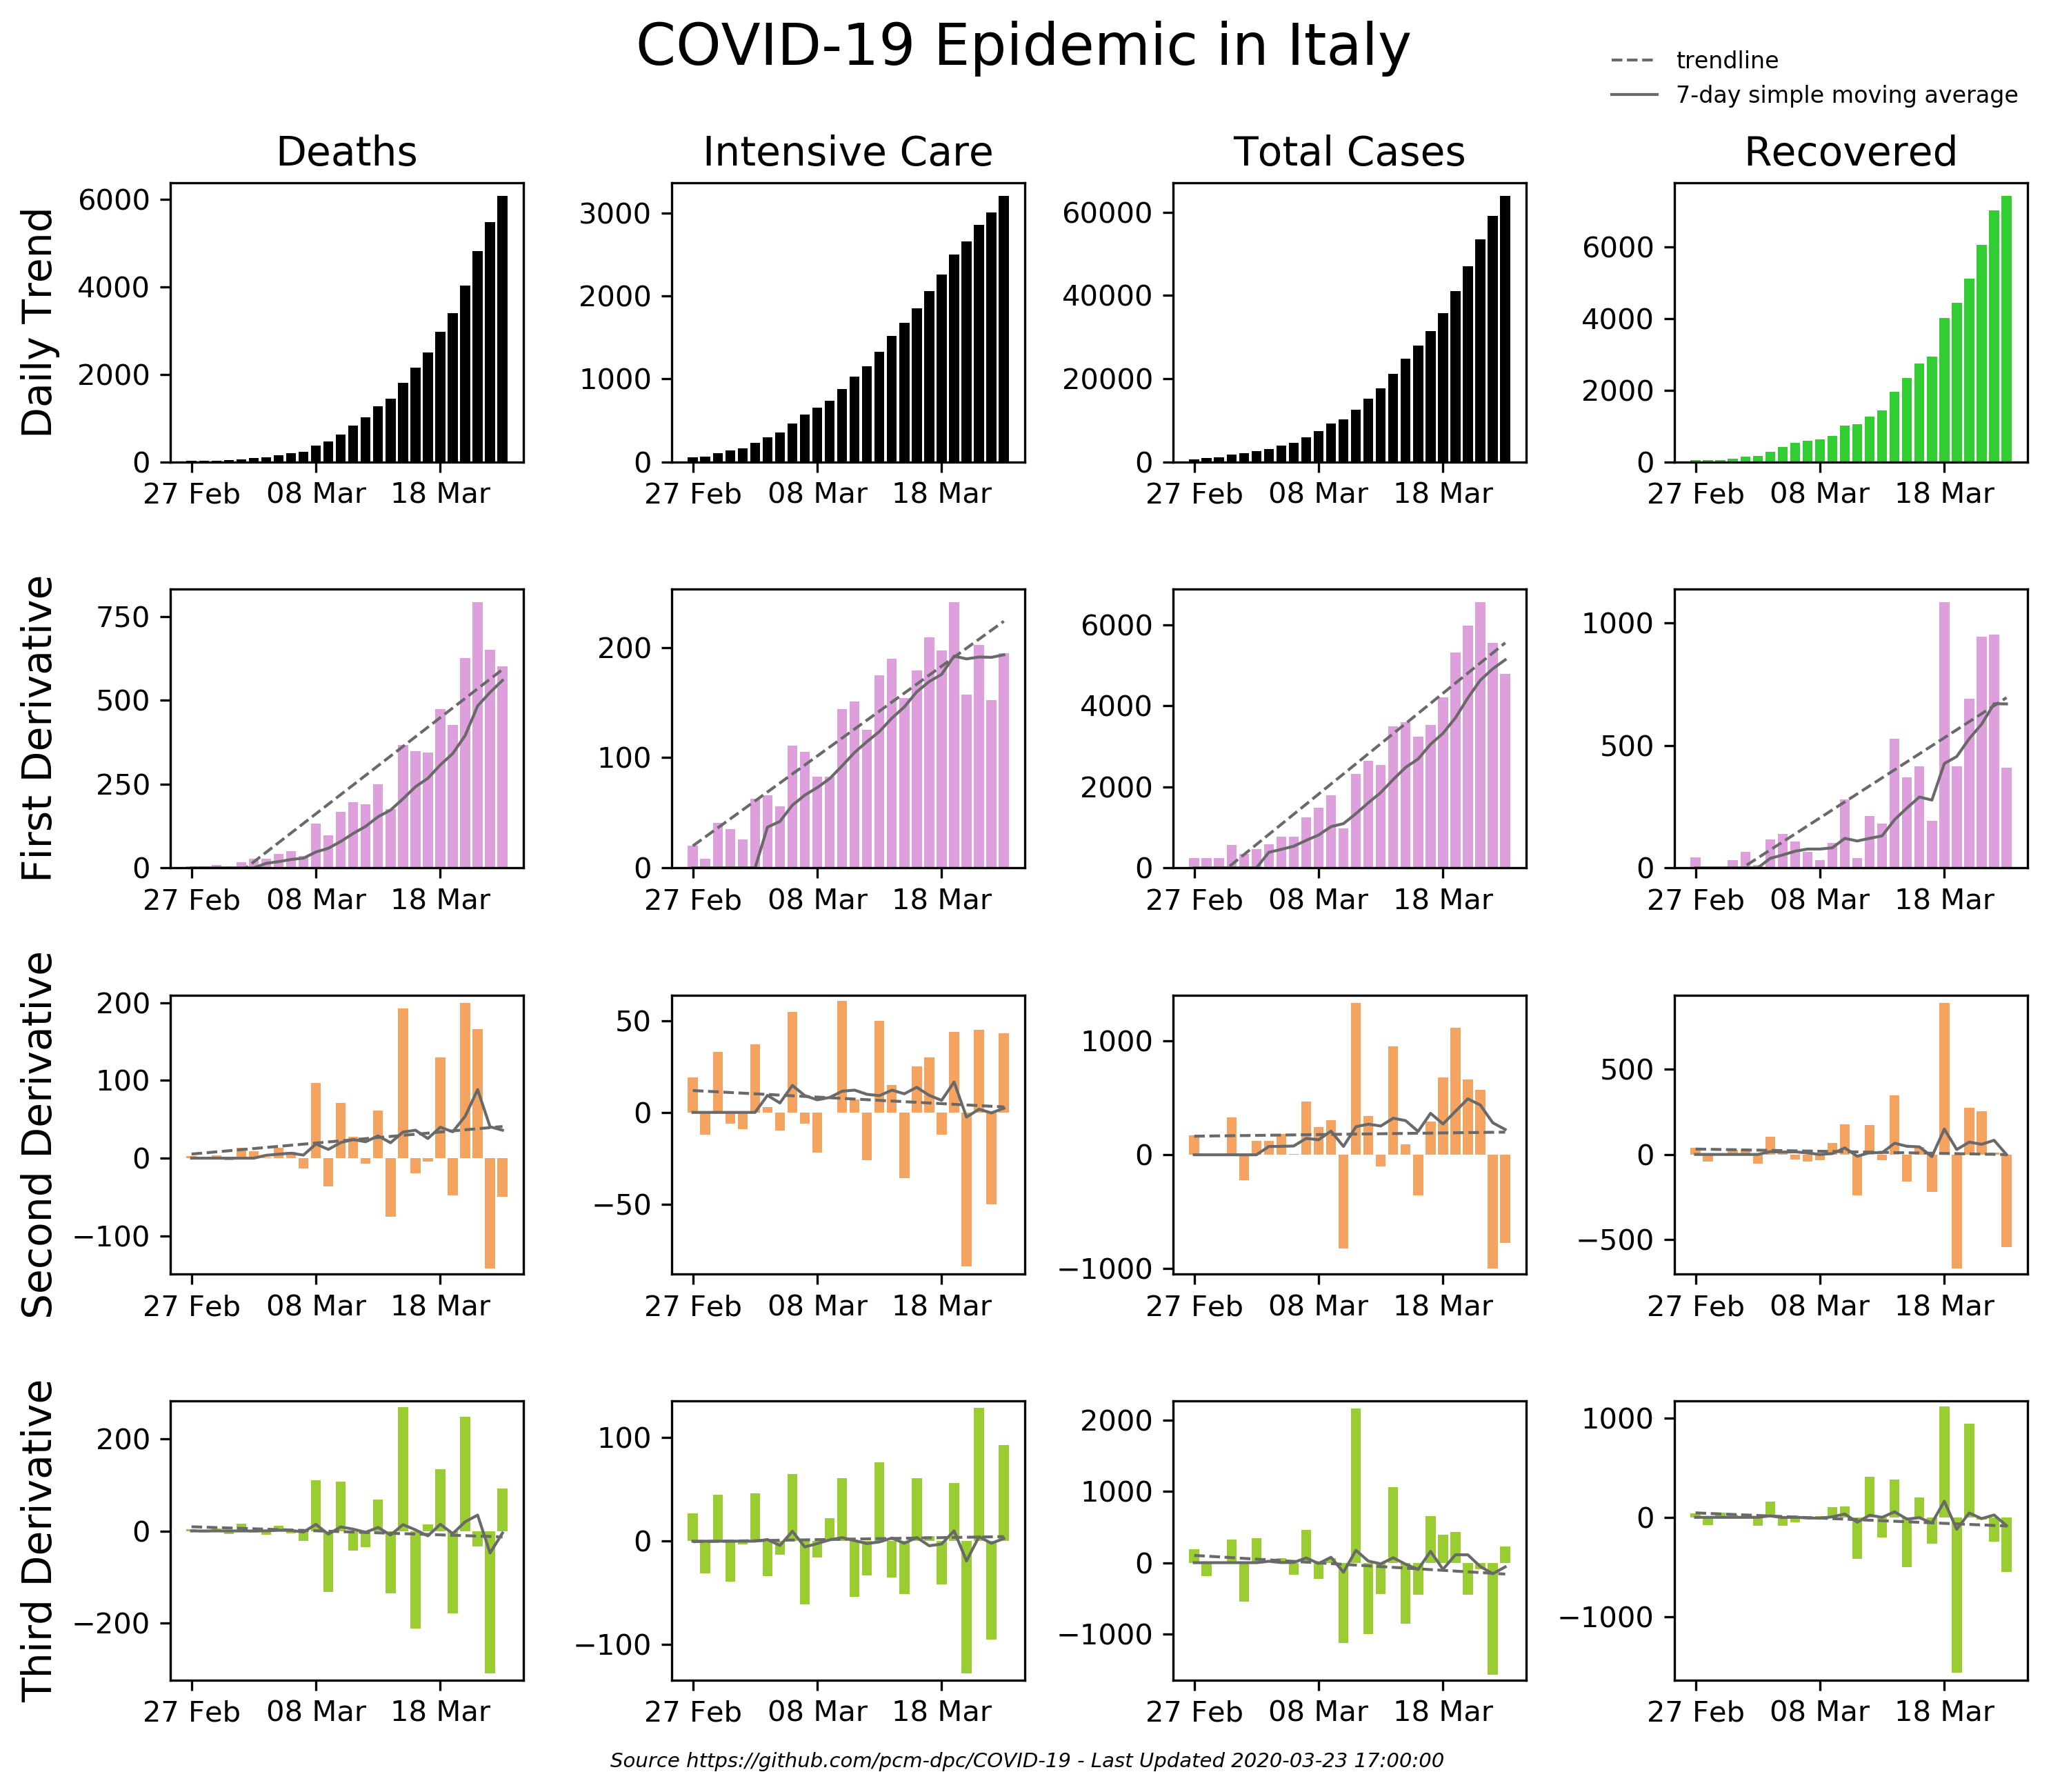

In [67]:
from matplotlib.lines import Line2D


moving_avg_days = 7

legend_lines = [Line2D([0], [0], color='dimgray', lw=1, ls='--'),
                Line2D([0], [0], color='dimgray', lw=1, ls='-')]
legend_labels = ('trendline', f'{moving_avg_days}-day simple moving average')


def plot(ax, measure, display_y_labels=False, main_color='black'):
    x = dataset['data']
    y = dataset[measure]

    ax[0].bar(x, y, color=main_color)
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax[0].set_title(measures[measure], fontsize=14)
    
    if display_y_labels:
        ax[0].set_ylabel('Daily Trend', fontsize=14)

    for i, sub_measure in enumerate(sub_measures):
        color = sub_measures[sub_measure]['color']
        label = sub_measures[sub_measure]['label']

        if display_y_labels:
            ax[i+1].set_ylabel(label, fontsize=14)

        y_sub = dataset[f'{measure}_{sub_measure}']
        ax[i+1].bar(x, y_sub, color=color, lw=1)

        # trendline
        z = np.polyfit(range(len(x)), y_sub, 1)
        p = np.poly1d(z)
        ax[i+1].plot(range(len(x)), p(range(len(x))), color='dimgray', lw=legend_lines[0].get_linewidth(), ls=legend_lines[0].get_linestyle())
        
        # n-day simple moving average
        rolling = y_sub.rolling(window=moving_avg_days).mean().fillna(value=0)
        ax[i+1].plot(range(len(x)), rolling, color='dimgray', lw=legend_lines[1].get_linewidth(), ls=legend_lines[1].get_linestyle())

        # limit number of x ticks
        ax[i+1].xaxis.set_major_locator(plt.MaxNLocator(3))

        # set range for y axes
        ax[i+1].set_ylim((min(0, y_sub.min()*1.05), y_sub.max()*1.05))


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8), dpi=300)

plot(axes[:, 0], 'deceduti', True)
plot(axes[:, 1], 'terapia_intensiva')
plot(axes[:, 2], 'totale_casi')
plot(axes[:, 3], 'dimessi_guariti', False, 'limegreen')

plt.tight_layout()

# legend, title and footer
fig.legend(legend_lines, legend_labels, loc=(0.781, 0.935), fontsize=8, frameon=False)
fig.suptitle('COVID-19 Epidemic in Italy', y=1.05, fontsize=20)
fig.text(0.3, -0.005, footer, fontsize=7, style='italic')
fig.align_ylabels()

plt.show()

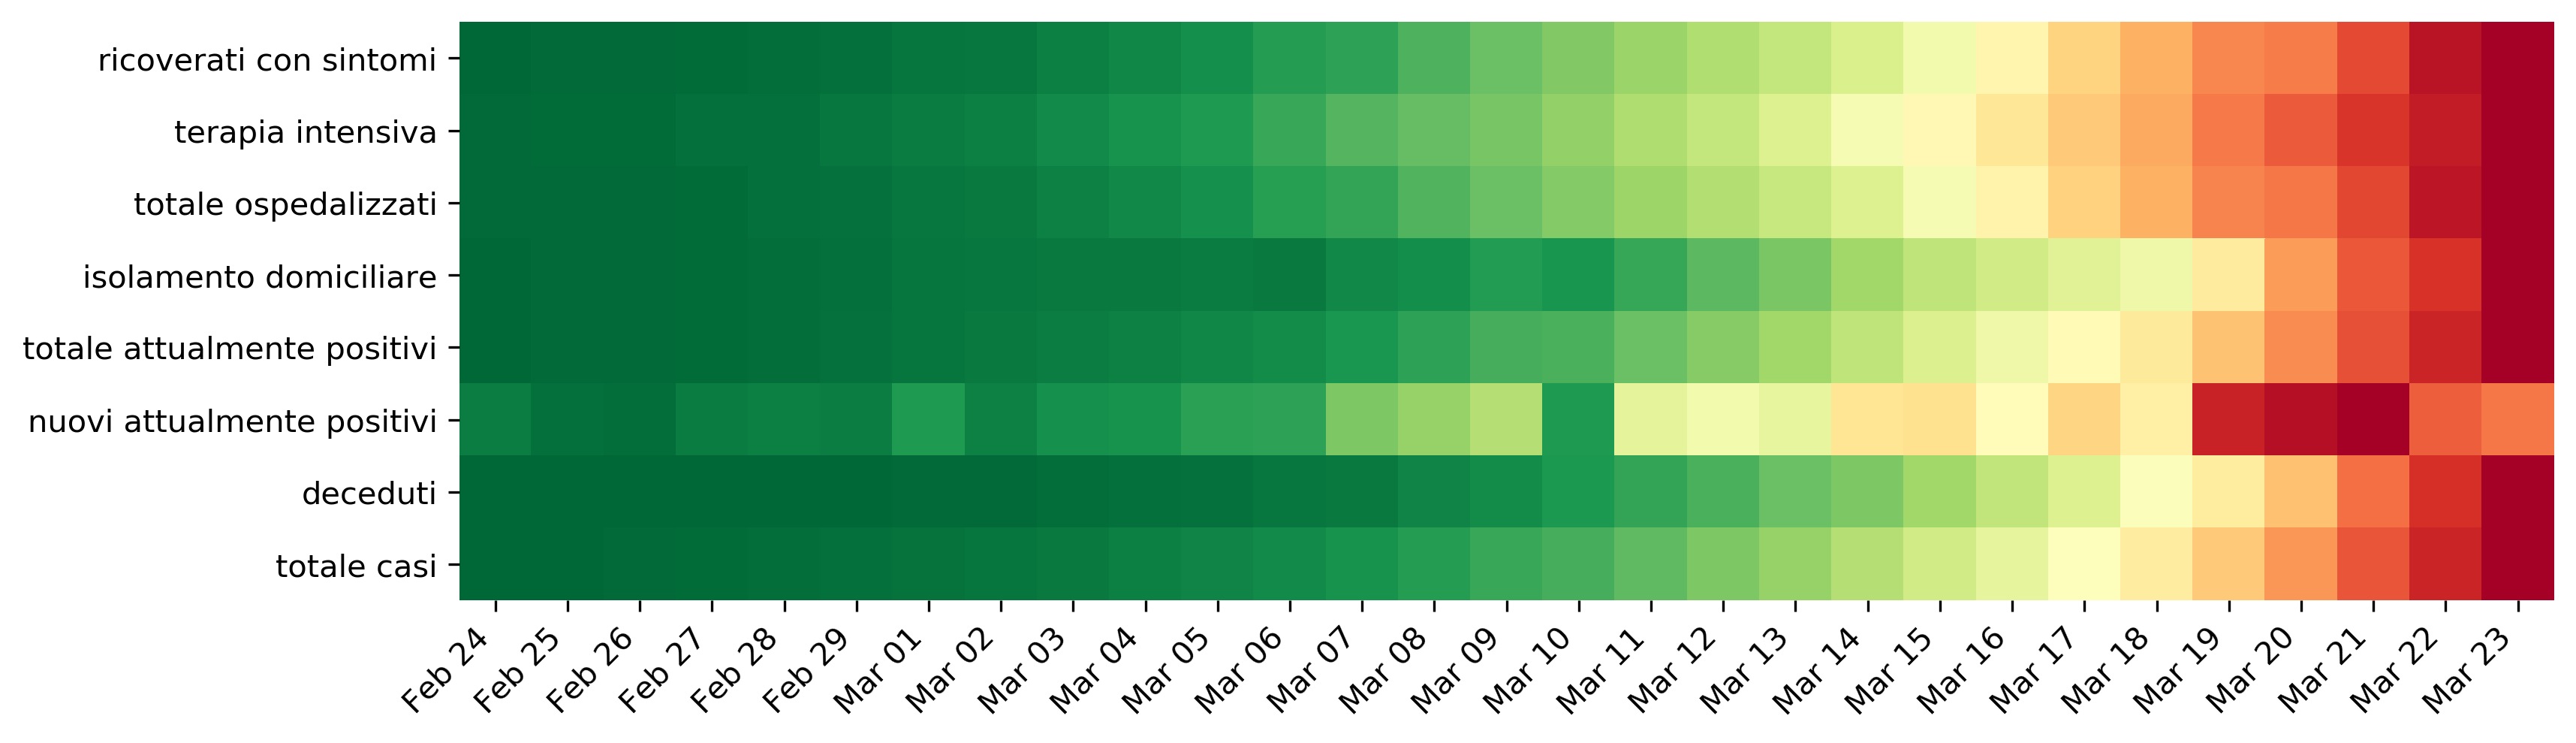

In [72]:
import seaborn as sns

dataset = pd.read_json(DATA_SOURCE, convert_dates=['data'])
dataset.drop(columns=['stato','dimessi_guariti','tamponi'],inplace=True)
dataset.set_index('data',inplace=True)
dataset = dataset / dataset.max()

fig, ax = plt.subplots(figsize=(12, 4), dpi=300)

g = sns.heatmap(dataset.transpose(), square=True, cbar=False, cmap='RdYlGn_r')
g.set_xticklabels(dataset.index.strftime('%b %d'), rotation=45, horizontalalignment='right')
# TODO: translate dataset columns
g.set_yticklabels(map(lambda s: s.replace('_', ' '), list(dataset.columns))) 

ax.set_xlabel('')
plt.show()

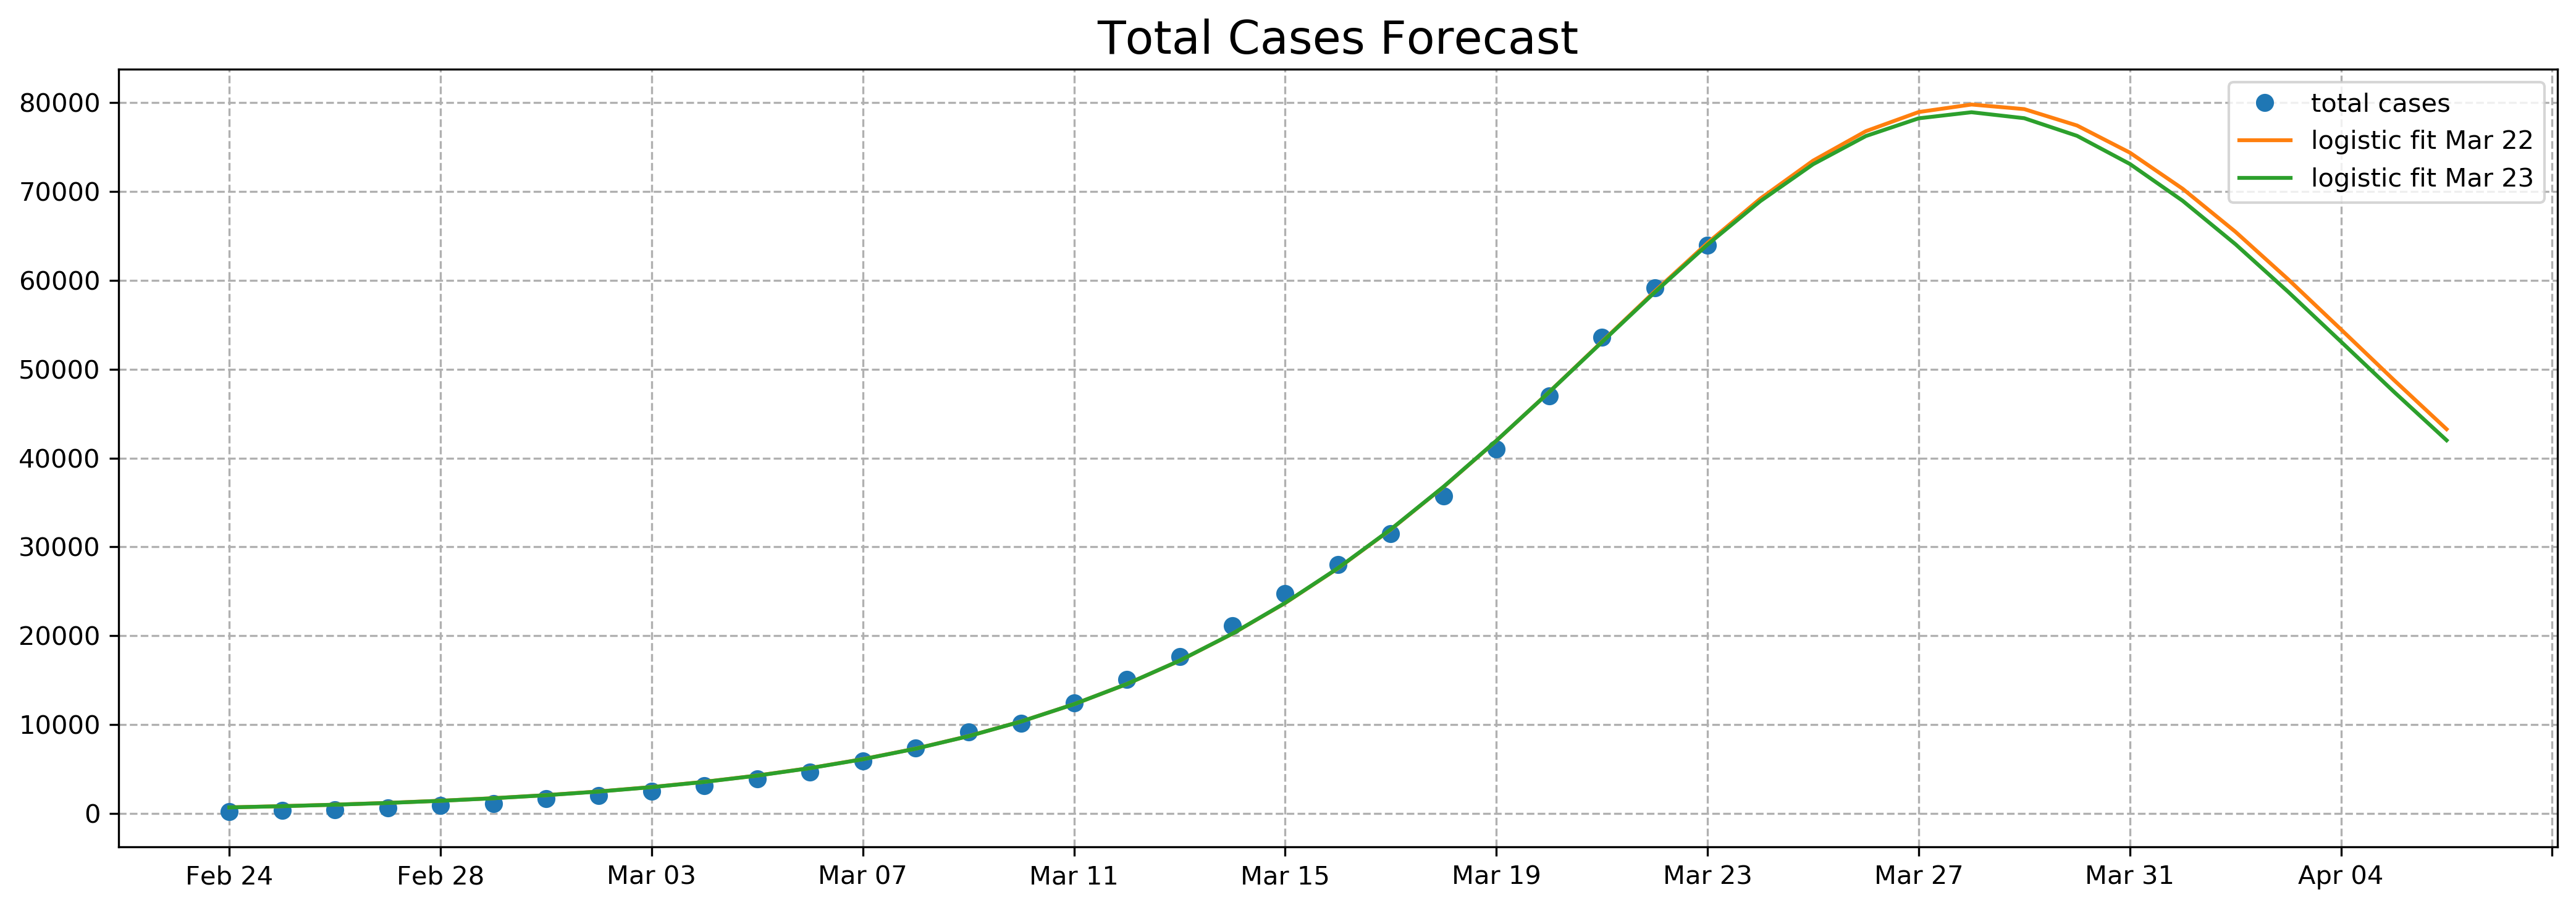

In [69]:
from scipy.optimize import curve_fit
from scipy.stats import logistic
from datetime import datetime
from datetime import timedelta
import requests 


FORECAST_DAYS = 14 
STORAGE_ENDPOINT='https://jsonbox.io/box_f39c57cdaa82a489cc24'


def logistic_amplified(x, loc, scale, c):
    return c * logistic.pdf(x, loc, scale)


def to_date_labels(arr):
    return list(map(lambda d: d.date().strftime('%b %d'), arr))


def get_data_from_storage(date):
    results = requests.get(url=f'{STORAGE_ENDPOINT}?q=date:{date.strftime("%Y-%m-%d")}').json()
    if len(results) > 0:
        return results[0]
    else:
        return None


def get_previous_curves():
    return requests.get(url=f'{STORAGE_ENDPOINT}?sort=date').json()


dataset = pd.read_json(DATA_SOURCE)
series = dataset['totale_casi']

dates = list(pd.to_datetime(dataset['data']))
extended_dates = dates + [dates[-1] + timedelta(days=1+i) for i in range(FORECAST_DAYS)]
today = dates[-1]

dates = to_date_labels(dates)
extended_dates = to_date_labels(extended_dates)

fig, axes = plt.subplots(figsize=(14,5), dpi=300)
axes.plot(dates,series,'o', label='total cases')

# fit logistic curve
x_base = range(len(dates))
popt, _ = curve_fit(logistic_amplified, x_base, series, p0=[27,1,250000])

# save curve parameters
if not get_data_from_storage(today):
    data = {
            'date': today.strftime('%Y-%m-%d'),
            'label': today.strftime('%b %d'),
            'curve': 'logistic',
            'optimum': list(popt)
           }
    requests.post(url = API_ENDPOINT, json = data) 

# plot logistic curve
x_extended = range(len(dates) + FORECAST_DAYS)

# plot curves from previous days
# Mar 22 > 33.12145714472205, 5.393198308640572, 1721492.1468747398
# Mar 23 > 33.004484543810214, 5.376470896238073, 1697265.5720018148
for curve in get_previous_curves():
    label = curve['label']
    parameters = curve['optimum']
    axes.plot(extended_dates, logistic_amplified(x_extended,*parameters), label=f'logistic fit {label}')
    
# makeup
axes.legend(loc='best')
axes.set_title('Total Cases Forecast', fontsize=18)
axes.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.grid(b=True, which='major', linestyle='--')
plt.tight_layout()

plt.show()